In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
# Chargement du fichier après pre-processing
df = pd.read_csv('tokenization_text_2.csv', index_col = 0)
display(df.head())

,designation,description,productid,imageid,target,text,tokens
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,0,olivia personalisiertes notizbuch seiten pu...,"['olivia', 'personalisiertes', 'notizbuch', 's..."
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,1,journal des arts le n du lart et son marche...,"['journal', 'arts', 'lart', 'marche', 'salon',..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,2,grand stylet ergonomique bleu gamepad nintendo...,"['grand', 'stylet', 'ergonomique', 'bleu', 'ga..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,3,peluche donald europe disneyland marionnett...,"['peluche', 'donald', 'europe', 'disneyland', ..."
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,4,la guerre des tuques luc a des idées de grande...,"['guerre', 'tuques', 'luc', 'idées', 'grandeur..."


In [3]:
# Afficher le nombre de lignes et de colonnes de chacun des deux fichiers
print("Le nombre de lignes et de colonnes de df est de :",df.shape)

Le nombre de lignes et de colonnes de df est de : (84916, 7)


In [4]:
# Renommer les colonnes :
df.rename(columns = {'text':'description complete', 'target':'prdtypecode'}, inplace = True)
df.head()

,designation,description,productid,imageid,prdtypecode,description complete,tokens
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,0,olivia personalisiertes notizbuch seiten pu...,"['olivia', 'personalisiertes', 'notizbuch', 's..."
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,1,journal des arts le n du lart et son marche...,"['journal', 'arts', 'lart', 'marche', 'salon',..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,2,grand stylet ergonomique bleu gamepad nintendo...,"['grand', 'stylet', 'ergonomique', 'bleu', 'ga..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,3,peluche donald europe disneyland marionnett...,"['peluche', 'donald', 'europe', 'disneyland', ..."
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,4,la guerre des tuques luc a des idées de grande...,"['guerre', 'tuques', 'luc', 'idées', 'grandeur..."


In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Affectation de X et y
X = df['description complete']
y = df['prdtypecode']

In [6]:
# classe minoritaire et nombre d'occurences

class_compteur = df['prdtypecode'].value_counts()
min_class = class_compteur.idxmin()
min_class_size = class_compteur.min()

print(f"La classe minoritaire est '{min_class}' avec {min_class_size} échantillons.")


La classe minoritaire est '13' avec 764 échantillons.


In [7]:
# Créer une instance de RandomUnderSampler
## (auto) équlibrage des classes en réduisant les classes à la même taille que celle de la classe minoritaire.
## replacement = False --> sous-ensembles composées d'échantillons uniques.

rus = RandomUnderSampler(sampling_strategy = 'auto', replacement = False, random_state = 42)

In [8]:
# Application de rus à X et y
# Note : rus s'attend à ce que X soit un df, donc nous devons le convertir en df
X_ru, y_ru = rus.fit_resample(X.to_frame(), y)

In [9]:
# Vérifier la distribution des classes après sous-échantillonnage
print('Classes échantillon après rus :', dict(pd.Series(y_ru).value_counts()))

## rus à fonctionné, on a bien le même nombre d'exemples dans chaque classe.

Classes échantillon après rus : {0: 764, 14: 764, 25: 764, 24: 764, 23: 764, 22: 764, 21: 764, 20: 764, 19: 764, 18: 764, 17: 764, 16: 764, 15: 764, 13: 764, 1: 764, 12: 764, 11: 764, 10: 764, 9: 764, 8: 764, 7: 764, 6: 764, 5: 764, 4: 764, 3: 764, 2: 764, 26: 764}


In [10]:
# Après le sous-échantillonnage
print(X_ru.shape, y_ru.shape)  
## Vérification si X_ru et y_ru ont le même nombre de lignes : ok


(20628, 1) (20628,)


In [11]:
# Convertissez X_ru en DataFrame si nécessaire
X_ru_df = X_ru.to_frame() if isinstance(X_ru, pd.Series) else X_ru
## df pour garantir la compatibilité avec les process de ML

In [12]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_ru_df, y_ru, test_size = 0.2, random_state = 42)

In [13]:
# Vérifiez à nouveau les dimensions
print(X_train.shape, y_train.shape)  
## Les dimensions correspondent bien : ok

(16502, 1) (16502,)


In [14]:
# Vérification que X_train contient des données textuelles
is_textual_data = all(isinstance(text, str) for text in X_train.iloc[:, 0])
print("Les données de X_train sont-elles textuelles ?", is_textual_data)


Les données de X_train sont-elles textuelles ? True


In [15]:
# Pipeline simplifié pour le test
pipeline_test = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

## tfidf : vectorisation
## rf : modele ML

In [16]:
# Grille de paramètres réduite pour sqrt
param_grid_test_sqrt = {
    'tfidf__max_features': [2000, 3000, 5000],
    'rf__n_estimators': [50, 100],
    'rf__max_features': ['sqrt'],
}

In [21]:
# Grille de paramètres réduite pour log2
param_grid_test_log2 = {
    'tfidf__max_features': [2000, 3000, 5000],
    'rf__n_estimators': [50, 100],
    'rf__max_features': ['log2'],
}

In [19]:
# GridSearchCV avec la grille réduite 'sqrt'
grid_search_test_sqrt = GridSearchCV(pipeline_test, param_grid_test_sqrt, cv = 5, scoring = 'f1_weighted', error_score = 'raise')

# Exécution du GridSearchCV avec la grille réduite
grid_search_test_sqrt.fit(X_train['description complete'], y_train)
print("Meilleurs Paramètres (Test):", grid_search_test_sqrt.best_params_)
print("Meilleure Précision (Test):", grid_search_test_sqrt.best_score_)

Meilleurs Paramètres (Test): {'rf__max_features': 'sqrt', 'rf__n_estimators': 100, 'tfidf__max_features': 5000}
Meilleure Précision (Test): 0.6981866059183935


In [22]:
# GridSearchCV avec la grille réduite 'log2'
grid_search_test_log2 = GridSearchCV(pipeline_test, param_grid_test_log2, cv = 5, scoring = 'f1_weighted', error_score = 'raise')

# Exécution du GridSearchCV avec la grille réduite
grid_search_test_log2.fit(X_train['description complete'], y_train)
print("Meilleurs Paramètres (Test):", grid_search_test_log2.best_params_)
print("Meilleure Précision (Test):", grid_search_test_log2.best_score_)

Meilleurs Paramètres (Test): {'rf__max_features': 'log2', 'rf__n_estimators': 100, 'tfidf__max_features': 5000}
Meilleure Précision (Test): 0.7090410492327802


In [26]:
## sqrt
# Utilisation du meilleur modèle trouvé par GridSearchCV pour faire des prédictions
best_model_sqrt = grid_search_test_sqrt.best_estimator_
y_pred_best_sqrt = best_model_sqrt.predict(X_test['description complete'])


In [28]:
## log 2
# Utilisation du meilleur modèle trouvé par GridSearchCV pour faire des prédictions
best_model_log2 = grid_search_test_log2.best_estimator_
y_pred_best_log2 = best_model_log2.predict(X_test['description complete'])

In [27]:
# Calcul de l'accuracy score pour les meilleures prédictions 'sqrt'
accuracy_best_sqrt = accuracy_score(y_test, y_pred_best_sqrt)
print("Accuracy Score (Meilleur Modèle):", accuracy_best_sqrt)

Accuracy Score (Meilleur Modèle): 0.7057682985942801


In [29]:
# Calcul de l'accuracy score pour les meilleures prédictions 'log2'
accuracy_best_log2 = accuracy_score(y_test, y_pred_best_log2)
print("Accuracy Score (Meilleur Modèle):", accuracy_best_log2)

Accuracy Score (Meilleur Modèle): 0.7098885118759088


In [30]:
# Calcul de la matrice de confusion pour les meilleures prédictions 'sqrt'
conf_matrix_best_sqrt = pd.crosstab(y_test,y_pred_best_sqrt,rownames = ['Classe réelle'], colnames = ['Classe prédite'],normalize = 'index')
#display("Matrice de Confusion (Meilleur Modèle pour sqrt):\n", conf_matrix_best_sqrt)

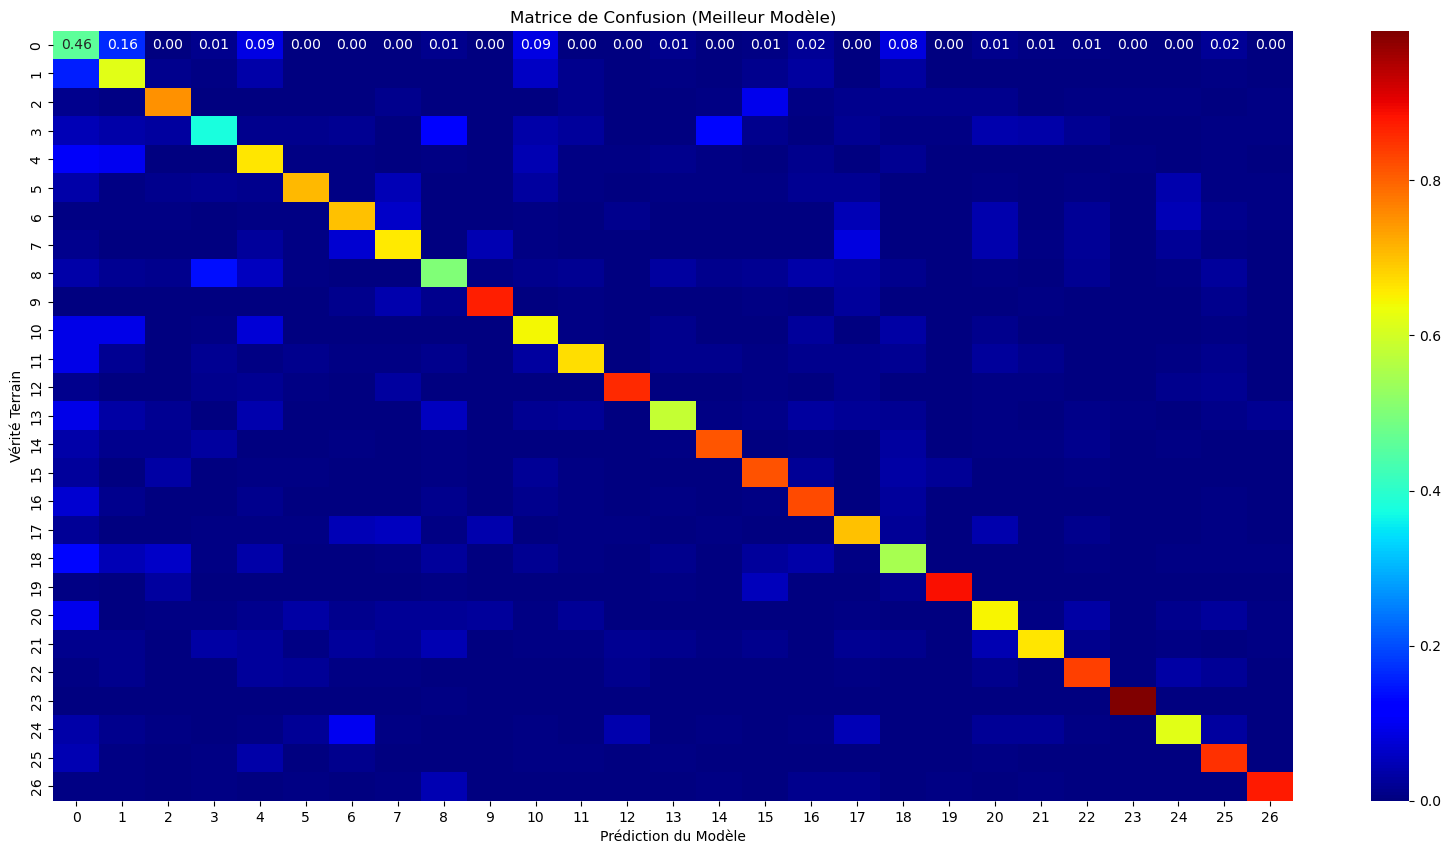

In [31]:
# Création de la heatmap 'sqrt'
plt.figure(figsize = (20, 10))
sns.heatmap(conf_matrix_best_sqrt, annot = True, fmt = '.2f', cmap = 'jet')

# Ajout de titres et d'étiquettes pour la clarté
plt.title('Matrice de Confusion (Meilleur Modèle)')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction du Modèle')

# Affichage du graphe
plt.show()

In [32]:
# Calcul de la matrice de confusion pour les meilleures prédictions 'log2'
conf_matrix_best_log2 = pd.crosstab(y_test,y_pred_best_log2,rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')
#display("Matrice de Confusion (Meilleur Modèle pour log 2):\n", conf_matrix_best_log2)

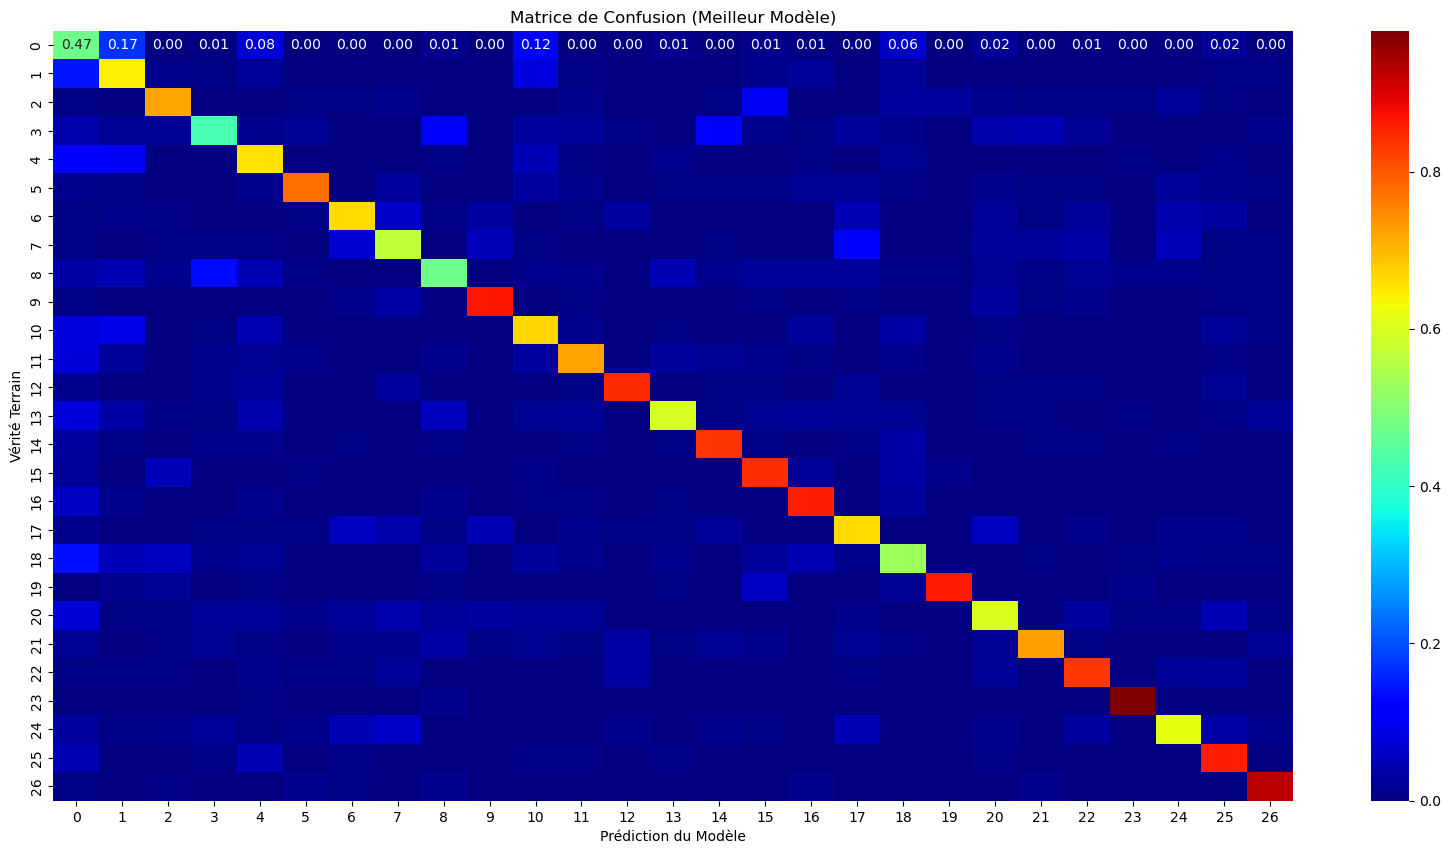

In [33]:
# Création de la heatmap 'log2'
plt.figure(figsize=(20, 10))  # Ajustez la taille selon vos besoins
sns.heatmap(conf_matrix_best_log2, annot=True, fmt='.2f', cmap='jet')

# Ajout de titres et d'étiquettes pour la clarté
plt.title('Matrice de Confusion (Meilleur Modèle)')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction du Modèle')

# Affichage du graphe
plt.show()

In [34]:
## test avec RandomizedSearchCV
# nous cherchons à trouver de meilleurs hyperparamètres

# Définitr l'espace des paramètres
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_dist = {
    'tfidf__max_features': sp_randint(1000, 10000),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # analyse des combinaisons jusqu'à 3 mots consécutifs
    'tfidf__min_df': sp_randint(1, 10), # fréquence des mots
    'tfidf__max_df': sp_uniform(0.7, 0.3), # fréquence entre 0.7 et 1 (distribution)
    'rf__n_estimators': sp_randint(50, 200), # nombre d'arbres dans la forêt
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__max_depth': sp_randint(10, 50),
    'rf__min_samples_split': sp_randint(2, 11),
    'rf__min_samples_leaf': sp_randint(1, 11)
}

In [35]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Configurer RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_test, 
    param_distributions = param_dist, 
    n_iter = 100,  # Nombre d'itérations de configuration de paramètres à essayer
    cv = 5,        # Stratégie de cross-validation
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'},  # Nos 2 scores sélectionnés
    refit = 'f1_weighted',  # f1-score pour refit le meilleur modèle
    random_state = 42,
    verbose = 5 # Affiche plus d'informations sur le processus
)

# Exécuter la recherche sur les données
random_search.fit(X_train.iloc[:, 0], y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END rf__max_depth=48, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=6, rf__n_estimators=152, tfidf__max_df=0.8337498258560773, tfidf__max_features=5426, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.642) f1_weighted: (test=0.650) total time=   2.3s
[CV 2/5] END rf__max_depth=48, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=6, rf__n_estimators=152, tfidf__max_df=0.8337498258560773, tfidf__max_features=5426, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.624) f1_weighted: (test=0.634) total time=   2.3s
[CV 3/5] END rf__max_depth=48, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=6, rf__n_estimators=152, tfidf__max_df=0.8337498258560773, tfidf__max_features=5426, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.617) f1_weighted: (test=0.628) total time=   2.4s
[CV 4/5] END rf__max_depth=48, rf__max_feature

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100,
                   param_distributions={'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x176d58350>,
                                        'rf__max_features': ['sqrt', 'log2',
                                                             None],
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_...
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x177bb4290>,
                                        'tfidf__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1764de6d0>,
                                        'tfidf__min_df': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177b971d0>,
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   random_state=42, refit='f1_weighted',
                   scoring={'accuracy': 'accuracy',
                            'f1_weighted': 'f1_weighted'},
                   verbose=5)

In [37]:
# Analyse des résultats

print("Meilleurs Paramètres:", random_search.best_params_)
print("Meilleure Précision:", random_search.best_score_)

# Meilleur modèle pour faire des prédictions sur l'ensemble de test
y_pred = random_search.predict(X_test.iloc[:, 0])

# Calcul et affichage de la performance sur l'ensemble de test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sur l'ensemble de test:", accuracy)


Meilleurs Paramètres: {'rf__max_depth': 49, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 73, 'tfidf__max_df': 0.8070259980080767, 'tfidf__max_features': 5859, 'tfidf__min_df': 9, 'tfidf__ngram_range': (1, 1)}
Meilleure Précision: 0.6640316439256706
Accuracy sur l'ensemble de test: 0.6619001454192923


J'affine ma recherche autour des valeurs que j'ai trouvé au début avec gridSearchCv :

tfidf__max_features : Je choisis une plage autour de 5000, mais j'étends la recherche (augmenter ou réduire ce nombre peut améliorer la performance).

tfidf__min_df et tfidf__max_df : Ces paramètres contrôlent la fréquence des termes pris en compte par le vectoriseur TF-IDF. Nous n'en avions pas mis dans GridSearchCV, nous prenons des valeurs standards (basses pour min et hautes pour max).

tfidf__ngram_range : Nous prenons en compte les groupes de un ou deux mots successifs, (les groupes de trois nous augmentent trop le temps de recherche).

rf__n_estimators : Nous restons autour de 100 comme trouvé avec GridSearchCV mais avec une marge haute et basse pour voir si nous pouvons obtenir des améliorations.

rf__max_features : Nous testons avec 'sqrt' et 'log2' sachant que nous avions des résultats relativement proche.

rf__max_depth, rf__min_samples_split, rf__min_samples_leaf : On évite le surajustement pour différentes profondeurs.

In [38]:
from scipy.stats import randint as sp_randin
from scipy.stats import uniform

param_dist_2 = {
    'tfidf__max_features': sp_randint(3000, 7000),  
    'tfidf__min_df': [1, 3, 5, 7, 9],  
    'tfidf__max_df': uniform(0.75, 0.95),  
    'tfidf__ngram_range': [(1, 1), (1, 2)],  
    'rf__n_estimators': sp_randint(80, 120),
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': sp_randint(2, 10),
    'rf__min_samples_leaf': sp_randint(1, 5)
}

In [39]:
# Config RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_test, 
    param_distributions = param_dist_2, 
    n_iter = 100,
    cv = 5,
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'},  # Nos 2 scores sélectionnés
    refit = 'f1_weighted',  # f1-score pour refit le meilleur modèle
    random_state = 42,
    verbose = 5 # Affiche plus d'informations sur le processus
)

# Exécuter la recherche sur les données
random_search.fit(X_train.iloc[:, 0], y_train) 


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=4, rf__n_estimators=87, tfidf__max_df=1.3187255599871848, tfidf__max_features=4638, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=nan) f1_weighted: (test=nan) total time=   0.0s
[CV 2/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=4, rf__n_estimators=87, tfidf__max_df=1.3187255599871848, tfidf__max_features=4638, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=nan) f1_weighted: (test=nan) total time=   0.0s
[CV 3/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=4, rf__n_estimators=87, tfidf__max_df=1.3187255599871848, tfidf__max_features=4638, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=nan) f1_weighted: (test=nan) total time=   0.0s
[CV 4/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
370 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_tr

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100,
                   param_distributions={'rf__max_depth': [None, 10, 20, 30, 40,
                                                          50],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28651ea90>,
                                        'rf__min_samples_spli...
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17c3f2710>,
                                        'tfidf__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x168d94f90>,
                                        'tfidf__min_df': [1, 3, 5, 7, 9],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)]},
                   random_state=42, refit='f1_weighted',
                   scoring={'accuracy': 'accuracy',
                            'f1_weighted': 'f1_weighted'},
                   verbose=5)

In [40]:
# Analyse des résultats

print("Meilleurs Paramètres:", random_search.best_params_)
print("Meilleure Précision:", random_search.best_score_)

# Utiliser le meilleur modèle pour faire des prédictions sur l'ensemble de test
y_pred = random_search.predict(X_test.iloc[:, 0])

# Calculer et afficher la performance sur l'ensemble de test
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sur l'ensemble de test:", accuracy)

Meilleurs Paramètres: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 91, 'tfidf__max_df': 0.9891931810340959, 'tfidf__max_features': 6457, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Meilleure Précision: 0.7170297995332812
Accuracy sur l'ensemble de test: 0.7210373242850218
